In [22]:
# Investment Portfolio Tracker - Jupyter Notebook
# Portfolio med startdato, indskud og daglig tracking
# Base Currency: DKK
# First executable (but unverified) code on 19-NOV-2025.

# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import yfinance as yf
import requests
from datetime import datetime, timedelta
import os
import matplotlib.pyplot as plt
import warnings
from jinja2 import Environment, PackageLoader

from nordnet_stock_ID import nordnet_stock_ID

warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [ ]:
# Cell 2: Configuration
TRANSACTIONS_FILE = 'transactions_thorleif.csv'
PORTFOLIO_CONFIG_FILE = 'portfolio_config_thorleif.csv'
BASE_CURRENCY = 'DKK'
BENCHMARK_TICKER = '^GSPC'  # Danish market benchmark
RISK_FREE_RATE = 0.03  # 3% annual risk-free rate (adjust as needed)

#end_date = pd.to_datetime('2025-04-01')
end_date = pd.to_datetime(datetime.now().strftime('%Y-%m-%d'))

print(f"Portfolio Configuration:")
print(f"  Transactions File: {TRANSACTIONS_FILE}")
print(f"  Portfolio Config File: {PORTFOLIO_CONFIG_FILE}")
print(f"  Base Currency: {BASE_CURRENCY}")
print(f"  Benchmark: {BENCHMARK_TICKER}")
print(f"  Risk-Free Rate: {RISK_FREE_RATE*100}%")

Portfolio Configuration:
  Transactions File: transactions_thorleif.csv
  Portfolio Config File: portfolio_config_thorleif.csv
  Base Currency: DKK
  Benchmark: OMXC25GI
  Risk-Free Rate: 3.0%


In [24]:
# Cell 3: Helper Functions

def get_nordnet_history(ticker, nordnet_stock_ID, start=None, end=None):
    """
    Henter historiske priser fra Nordnet API
    Returnerer pandas DataFrame i samme format som yf.Ticker().history()
    
    Args:
        ticker: Ticker symbol (f.eks. 'NOVO-B.CO')
        nordnet_stock_ID: Dictionary med ticker -> [name, instrument_id]
        start: Start date (bruges til at filtrere efter hentning)
    
    Returns:
        pandas DataFrame med DatetimeIndex og kolonner: Open, High, Low, Close, Volume
    """
    import requests
    from datetime import datetime
    import pandas as pd
    
    # Check if ticker exists in Nordnet database
    if ticker not in nordnet_stock_ID:
        raise ValueError(f"Ticker {ticker} not found in nordnet_stock_ID. Please add it or use yfinance.")
    
    instrument = nordnet_stock_ID[ticker]
    instrument_id = instrument[1]
    
    # Prepare session
    session = requests.Session()
    session.headers['Origin'] = 'https://www.nordnet.dk'
    
    # Fetch data from Nordnet
    url = f'https://api.prod.nntech.io/market-data/price-time-series/v2/period/YEAR_5/identifier/{instrument_id}'
    params = {
        'resolution': 'DAY',
        'enrichType': 'ALL'            
    }
    
    try:
        response = session.get(url, params=params)
        response.raise_for_status()
        jsondecode = response.json()
    except Exception as e:
        raise Exception(f"Error fetching data from Nordnet for {ticker}: {e}")
    
    # Parse data into list of dictionaries
    data_rows = []
    for day in jsondecode['pricePoints']:
        timestamp = day['timeStamp']
        date_datetime = datetime.fromtimestamp(timestamp / 1000)
        
        data_rows.append({
            'Date': date_datetime,
            'Open': float(day['open']),
            'High': float(day['high']),
            'Low': float(day['low']),
            'Close': float(day['last']),
            'Volume': int(day['volume'])
        })
    
    # Create DataFrame
    df = pd.DataFrame(data_rows)
    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True)
    
    # Filter by start date if provided
    if start is not None:
        start_date = pd.to_datetime(start)
        df = df[df.index >= start_date]

    if end is not None:
        end_date = pd.to_datetime(end)
        df = df[df.index <= end_date]
    
    return df

def load_portfolio_config():
    """Load portfolio configuration (start date and initial deposit)"""
    if os.path.exists(PORTFOLIO_CONFIG_FILE):
        df = pd.read_csv(PORTFOLIO_CONFIG_FILE)
        config = df.iloc[0].to_dict()
        print(f"✓ Loaded portfolio config: Start date: {config['start_date']}, Initial deposit: {config['initial_deposit']} {config['currency']}")
        return config
    else:
        print("ℹ No portfolio config found. Please create one using Cell 4.")
        return None

def save_portfolio_config(start_date, initial_deposit, currency=BASE_CURRENCY):
    """Save portfolio configuration"""
    config_df = pd.DataFrame({
        'start_date': [start_date],
        'initial_deposit': [initial_deposit],
        'currency': [currency]
    })
    config_df.to_csv(PORTFOLIO_CONFIG_FILE, index=False)
    print(f"✓ Portfolio config saved: Start {start_date}, Deposit {initial_deposit} {currency}")

def load_transactions():
    """Load transactions from CSV file"""
    if os.path.exists(TRANSACTIONS_FILE):
        df = pd.read_csv(TRANSACTIONS_FILE)
        print(f"✓ Loaded {len(df)} transactions from {TRANSACTIONS_FILE}")
        return df
    else:
        print(f"ℹ No existing transactions file. Creating new one.")
        return pd.DataFrame(columns=['date', 'ticker', 'action', 'quantity', 'price', 'currency', 'dividend_amount', 'transaction_fee', 'fx_fee'])

def save_transactions(df):
    """Save transactions to CSV file"""
    df.to_csv(TRANSACTIONS_FILE, index=False)
    print(f"✓ Saved {len(df)} transactions to {TRANSACTIONS_FILE}")

def get_exchange_rate(from_currency, to_currency=BASE_CURRENCY):
    """Get exchange rate from currency to base currency"""
    if from_currency == to_currency:
        return 1.0
    
    try:
        url = f"https://api.exchangerate-api.com/v4/latest/{from_currency}"
        response = requests.get(url, timeout=5)
        data = response.json()
        return data['rates'].get(to_currency, 1.0)
    except Exception as e:
        fallback_rates = {'USD': 7.0, 'EUR': 7.45, 'GBP': 8.7, 'DKK': 1.0}
        return fallback_rates.get(from_currency, 1.0)

def get_current_prices1(tickers):
    """Fetch current prices for list of tickers"""
    prices = {}
    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            hist = stock.history(period='1d')
            print(stock)
            if not hist.empty:
                prices[ticker] = hist['Close'].iloc[-1]
                print(f"  ✓ {ticker}: {prices[ticker]:.2f}")
            else:
                prices[ticker] = None
        except Exception as e:
            print(f"  ✗ Error fetching {ticker}: {e}")
            prices[ticker] = None
    return prices

def get_current_prices(tickers, nordnet_stock_ID=None, start=None, end=None):
    """
    Fetch current prices for list of tickers
    Uses Nordnet for Danish stocks (.CO), yfinance for others
    
    Args:
        tickers: List of ticker symbols
        nordnet_stock_ID: Dictionary with Nordnet instrument IDs (optional)
    
    Returns:
        Dictionary with ticker -> current price (float)
    """
    prices = {}
    for ticker in tickers:
        try:
            # Automatic detection: Use Nordnet for Danish stocks if available
            if ticker.endswith('.CO') and nordnet_stock_ID and ticker in nordnet_stock_ID:
                # Get latest price from Nordnet (last day of historical data)
                hist = get_nordnet_history(ticker, nordnet_stock_ID, start=start, end=end)
                if not hist.empty:
                    prices[ticker] = hist['Close'].iloc[-1]
                    print(f"  ✓ {ticker}: {prices[ticker]:.2f} (Nordnet)")
                else:
                    prices[ticker] = None
            else:
                # Use yfinance
                stock = yf.Ticker(ticker)
                hist = stock.history(period='1d')
                if not hist.empty:
                    prices[ticker] = hist['Close'].iloc[-1]
                    print(f"  ✓ {ticker}: {prices[ticker]:.2f} (YF)")
                else:
                    prices[ticker] = None
        except Exception as e:
            print(f"  ✗ Error fetching {ticker}: {e}")
            prices[ticker] = None
    return prices

def get_historical_prices1(tickers, start_date):
    """Fetch historical prices for tickers from start_date to today"""
    all_prices = {}
    
    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            hist = stock.history(start=start_date)
            if not hist.empty:
                all_prices[ticker] = hist['Close']
                print(f"  ✓ {ticker}: {len(hist)} days of data")
            else:
                print(f"  ⚠ No historical data for {ticker}")
                all_prices[ticker] = None
        except Exception as e:
            print(f"  ✗ Error fetching {ticker}: {e}")
            all_prices[ticker] = None
    
    return all_prices

def get_historical_prices(tickers, start_date, nordnet_stock_ID=None):
    """
    Fetch historical prices - uses Nordnet for Danish stocks (.CO), yfinance for others
    
    Args:
        tickers: List of ticker symbols
        start_date: Start date for historical data
        nordnet_stock_ID: Dictionary with Nordnet instrument IDs (optional)
    
    Returns:
        Dictionary with ticker -> price series (pandas Series)
    """
    all_prices = {}
    
    for ticker in tickers:
        try:
            # Automatic detection: Use Nordnet for Danish stocks if available
            if ticker.endswith('.CO') and nordnet_stock_ID and ticker in nordnet_stock_ID:
                print(f"  Fetching {ticker} from Nordnet...")
                hist = get_nordnet_history(ticker, nordnet_stock_ID, start=start_date)
            else:
                print(f"  Fetching {ticker} from Yahoo Finance...")
                stock = yf.Ticker(ticker)
                hist = stock.history(start=start_date)
            
            if not hist.empty:
                all_prices[ticker] = hist['Close']
                print(f"  ✓ {ticker}: {len(hist)} days")
            else:
                print(f"  ⚠ No data for {ticker}")
        except Exception as e:
            print(f"  ✗ {ticker}: {e}")
    
    return all_prices

def calculate_cash_balance(transactions, portfolio_config):
    """Calculate current cash balance from deposits and transactions"""
    if portfolio_config is None:
        return 0
    
    # Start with initial deposit
    rate = get_exchange_rate(portfolio_config['currency'])
    cash_balance = portfolio_config['initial_deposit'] * rate
    
    # Process all transactions
    for _, row in transactions.iterrows():
        trans_rate = get_exchange_rate(row['currency'])
        transaction_fee = row.get('transaction_fee', 0)
        fx_fee = row.get('fx_fee', 0)
        
        if pd.isna(transaction_fee):
            transaction_fee = 0
        if pd.isna(fx_fee):
            fx_fee = 0
        
        if row['action'] == 'buy':
            # Buying reduces cash (cost + fees)
            total_cost = row['quantity'] * row['price'] * trans_rate
            cash_balance -= total_cost + transaction_fee + fx_fee
        elif row['action'] == 'sell':
            # Selling increases cash (proceeds - fees)
            total_proceeds = row['quantity'] * row['price'] * trans_rate
            cash_balance += total_proceeds - transaction_fee - fx_fee
        elif row['action'] == 'dividend':
            # Dividends increase cash
            dividend_amt = row.get('dividend_amount', 0)
            if pd.notna(dividend_amt):
                cash_balance += dividend_amt * trans_rate
    
    return cash_balance

def calculate_holdings_at_date(transactions, target_date):
    """Calculate holdings at a specific date"""
    holdings = {}
    
    transactions_to_date = transactions[pd.to_datetime(transactions['date']) <= pd.to_datetime(target_date)]
    
    for _, row in transactions_to_date.iterrows():
        if row['action'] in ['buy', 'sell']:
            ticker = row['ticker']
            if ticker not in holdings:
                holdings[ticker] = {
                    'quantity': 0,
                    'total_cost': 0,
                    'currency': row['currency']
                }
            
            if row['action'] == 'buy':
                holdings[ticker]['quantity'] += row['quantity']
                holdings[ticker]['total_cost'] += row['quantity'] * row['price']
            elif row['action'] == 'sell':
                holdings[ticker]['quantity'] -= row['quantity']
                holdings[ticker]['total_cost'] -= row['quantity'] * row['price']
    
    # Remove stocks with 0 or negative quantity
    holdings = {k: v for k, v in holdings.items() if v['quantity'] > 0}
    return holdings

def calculate_portfolio_metrics(daily_returns, benchmark_returns, risk_free_rate=RISK_FREE_RATE):
    """Calculate Alpha, Beta, and Sharpe Ratio"""
    
    # Align the series
    aligned_data = pd.DataFrame({
        'portfolio': daily_returns,
        'benchmark': benchmark_returns
    }).dropna()
    
    if len(aligned_data) < 30:  # Need at least 30 days of data
        return None, None, None, None
    
    portfolio_returns = aligned_data['portfolio']
    benchmark_returns = aligned_data['benchmark']
    
    # Calculate Beta using covariance method
    covariance = portfolio_returns.cov(benchmark_returns)
    benchmark_variance = benchmark_returns.var()
    beta = covariance / benchmark_variance if benchmark_variance != 0 else 0
    
    # Calculate Alpha (annualized)
    # Alpha = Portfolio Return - (Risk Free Rate + Beta * (Benchmark Return - Risk Free Rate))
    portfolio_return_annual = portfolio_returns.mean() * 252  # Annualize daily returns
    benchmark_return_annual = benchmark_returns.mean() * 252
    alpha = portfolio_return_annual - (risk_free_rate + beta * (benchmark_return_annual - risk_free_rate))
    
    # Calculate Sharpe Ratio (annualized)
    excess_returns = portfolio_returns - (risk_free_rate / 252)  # Daily risk-free rate
    sharpe_ratio = (excess_returns.mean() / excess_returns.std()) * np.sqrt(252) if excess_returns.std() != 0 else 0
    
    # Calculate correlation
    correlation = portfolio_returns.corr(benchmark_returns)
    
    return alpha, beta, sharpe_ratio, correlation

print("✓ Helper functions defined")


✓ Helper functions defined


In [25]:
# Cell 4: Create New Portfolio
# RUN THIS CELL ONCE to create a new portfolio
# Modify these values before running:

# start_date = "2025-01-03"  # Start date for portfolio (YYYY-MM-DD)
# initial_deposit = 1000000   # Initial deposit amount
# currency = "DKK"           # Currency of initial deposit

# save_portfolio_config(start_date, initial_deposit, currency)
# print(f"\n✓ Portfolio created!")
# print(f"  Start Date: {start_date}")
# print(f"  Initial Deposit: {initial_deposit} {currency}")


In [26]:
# Cell 5: Load Portfolio Configuration
portfolio_config = load_portfolio_config()

if portfolio_config:
    print(f"\n📊 Current Portfolio Configuration:")
    print(f"  Start Date: {portfolio_config['start_date']}")
    print(f"  Initial Deposit: {portfolio_config['initial_deposit']} {portfolio_config['currency']}")
    
    # Calculate in DKK
    rate = get_exchange_rate(portfolio_config['currency'])
    initial_in_dkk = portfolio_config['initial_deposit'] * rate
    print(f"  Initial Deposit in {BASE_CURRENCY}: {initial_in_dkk:,.2f}")


✓ Loaded portfolio config: Start date: 2024-12-30, Initial deposit: 1000000 DKK

📊 Current Portfolio Configuration:
  Start Date: 2024-12-30
  Initial Deposit: 1000000 DKK
  Initial Deposit in DKK: 1,000,000.00


In [27]:
# Cell 6: Load Transactions
transactions = load_transactions()

if not transactions.empty:
    print(f"\n✓ Loaded {len(transactions)} transactions")
    print("\nLatest transactions:")
    display(transactions.tail())
else:
    print("\nNo transactions yet. Use the cells below to add some!")


✓ Loaded 29 transactions from transactions_thorleif.csv

✓ Loaded 29 transactions

Latest transactions:


,date,ticker,action,quantity,price,currency,dividend_amount,transaction_fee,fx_fee
24,2025-06-30,GMAB.CO,buy,53.0,1315.0,DKK,NaN,0.0,0.0
25,2025-06-30,COLO-B.CO,buy,115.0,601.6,DKK,NaN,0.0,0.0
26,2025-06-30,SPG.CO,buy,219.0,314.0,DKK,NaN,0.0,0.0
27,2025-09-30,DNORD.CO,dividend,0.0,0.0,DKK,850.0,0.0,0.0
28,2025-09-30,NOVO-B.CO,dividend,0.0,0.0,DKK,562.5,0.0,0.0


In [28]:
# Cell 7: Add BUY Transaction
# Modify these values and run the cell to add a BUY transaction

# ticker = "AAPL"  # Stock ticker symbol
# quantity = 10     # Number of shares
# price = 150.00    # Price per share
# currency = "USD"  # Currency (USD, EUR, GBP, DKK)
# transaction_fee = 10.00  # Transaction fee in DKK (e.g., broker fee)
# fx_fee = 5.00     # FX fee in DKK (currency exchange fee)
# date = datetime.now().strftime('%Y-%m-%d')  # Leave as is for today, or use 'YYYY-MM-DD'

# # Add transaction
# new_transaction = pd.DataFrame({
#     'date': [date],
#     'ticker': [ticker.upper()],
#     'action': ['buy'],
#     'quantity': [float(quantity)],
#     'price': [float(price)],
#     'currency': [currency.upper()],
#     'dividend_amount': [None],
#     'transaction_fee': [float(transaction_fee)],
#     'fx_fee': [float(fx_fee)]
# })

# transactions = pd.concat([transactions, new_transaction], ignore_index=True)
# save_transactions(transactions)

# total_cost_original = quantity * price
# trans_rate = get_exchange_rate(currency)
# total_cost_dkk = total_cost_original * trans_rate
# total_fees = transaction_fee + fx_fee
# total_with_fees = total_cost_dkk + total_fees

# print(f"✓ Added BUY: {quantity} shares of {ticker.upper()} at {price} {currency}")
# print(f"  Cost: {total_cost_dkk:,.2f} {BASE_CURRENCY}")
# print(f"  Transaction fee: {transaction_fee:,.2f} {BASE_CURRENCY}")
# print(f"  FX fee: {fx_fee:,.2f} {BASE_CURRENCY}")
# print(f"  Total cost (incl. fees): {total_with_fees:,.2f} {BASE_CURRENCY}")
# print(f"Total transactions: {len(transactions)}")

# # Calculate and show remaining cash
# cash_balance = calculate_cash_balance(transactions, portfolio_config)
# print(f"💰 Remaining cash: {cash_balance:,.2f} {BASE_CURRENCY}")


In [29]:
# Cell 8: Add SELL Transaction
# Modify these values and run the cell to add a SELL transaction

# ticker = "AAPL"  # Stock ticker symbol
# quantity = 5      # Number of shares
# price = 160.00    # Price per share
# currency = "USD"  # Currency (USD, EUR, GBP, DKK)
# transaction_fee = 10.00  # Transaction fee in DKK (e.g., broker fee)
# fx_fee = 5.00     # FX fee in DKK (currency exchange fee)
# date = datetime.now().strftime('%Y-%m-%d')  # Leave as is for today, or use 'YYYY-MM-DD'

# # Add transaction
# new_transaction = pd.DataFrame({
#     'date': [date],
#     'ticker': [ticker.upper()],
#     'action': ['sell'],
#     'quantity': [float(quantity)],
#     'price': [float(price)],
#     'currency': [currency.upper()],
#     'dividend_amount': [None],
#     'transaction_fee': [float(transaction_fee)],
#     'fx_fee': [float(fx_fee)]
# })

# transactions = pd.concat([transactions, new_transaction], ignore_index=True)
# save_transactions(transactions)

# total_proceeds_original = quantity * price
# trans_rate = get_exchange_rate(currency)
# total_proceeds_dkk = total_proceeds_original * trans_rate
# total_fees = transaction_fee + fx_fee
# net_proceeds = total_proceeds_dkk - total_fees

# print(f"✓ Added SELL: {quantity} shares of {ticker.upper()} at {price} {currency}")
# print(f"  Proceeds: {total_proceeds_dkk:,.2f} {BASE_CURRENCY}")
# print(f"  Transaction fee: {transaction_fee:,.2f} {BASE_CURRENCY}")
# print(f"  FX fee: {fx_fee:,.2f} {BASE_CURRENCY}")
# print(f"  Net proceeds (after fees): {net_proceeds:,.2f} {BASE_CURRENCY}")
# print(f"Total transactions: {len(transactions)}")

# # Calculate and show remaining cash
# cash_balance = calculate_cash_balance(transactions, portfolio_config)
# print(f"💰 Remaining cash: {cash_balance:,.2f} {BASE_CURRENCY}")


In [30]:
# Cell 9: Add DIVIDEND (Aktieudbytte)
# Modify these values and run the cell to add a DIVIDEND transaction

# ticker = "PNDORA.CO"       # Stock ticker symbol
# dividend_amount = 1400  # Total dividend received (in the specified currency)
# currency = "DKK"      # Currency (USD, EUR, GBP, DKK)
# #date = datetime.now().strftime('%Y-%m-%d')  # Leave as is for today, or use 'YYYY-MM-DD'
# date = pd.to_datetime('2025-03-01')  # Parses and formats the date

# # Add dividend transaction
# new_transaction = pd.DataFrame({
#     'date': [date],
#     'ticker': [ticker.upper()],
#     'action': ['dividend'],
#     'quantity': [0],
#     'price': [0],
#     'currency': [currency.upper()],
#     'dividend_amount': [float(dividend_amount)],
#     'transaction_fee': [0],
#     'fx_fee': [0]
# })

# transactions = pd.concat([transactions, new_transaction], ignore_index=True)
# save_transactions(transactions)

# trans_rate = get_exchange_rate(currency)
# dividend_dkk = dividend_amount * trans_rate

# print(f"✓ Added DIVIDEND: {dividend_amount} {currency} from {ticker.upper()}")
# print(f"  Value in {BASE_CURRENCY}: {dividend_dkk:,.2f}")
# print(f"Total transactions: {len(transactions)}")

# # Calculate and show remaining cash
# cash_balance = calculate_cash_balance(transactions, portfolio_config)
# print(f"💰 Cash balance (including dividend): {cash_balance:,.2f} {BASE_CURRENCY}")


In [31]:
# Cell 10: View All Transactions
transactions_sorted = transactions.sort_values('date', ascending=False)
print(f"📋 Transaction History ({len(transactions)} total)\n")
display(transactions_sorted)



📋 Transaction History (29 total)



,date,ticker,action,quantity,price,currency,dividend_amount,transaction_fee,fx_fee
28,2025-09-30,NOVO-B.CO,dividend,0.0,0.0,DKK,562.5,0.0,0.0
27,2025-09-30,DNORD.CO,dividend,0.0,0.0,DKK,850.0,0.0,0.0
26,2025-06-30,SPG.CO,buy,219.0,314.0,DKK,NaN,0.0,0.0
25,2025-06-30,COLO-B.CO,buy,115.0,601.6,DKK,NaN,0.0,0.0
24,2025-06-30,GMAB.CO,buy,53.0,1315.0,DKK,NaN,0.0,0.0
23,2025-06-30,UIE.CO,sell,300.0,307.5,DKK,NaN,0.0,0.0
22,2025-06-30,DSV.CO,sell,60.0,1522.0,DKK,NaN,0.0,0.0
21,2025-06-01,STG.CO,dividend,0.0,0.0,DKK,8075.0,0.0,0.0
20,2025-06-01,DNORD.CO,dividend,0.0,0.0,DKK,850.0,0.0,0.0
19,2025-06-01,UIE.CO,dividend,0.0,0.0,DKK,1773.0,0.0,0.0


In [32]:
# Cell 11: Current Portfolio Status
if portfolio_config is None:
    print("Please create a portfolio configuration first (Cell 4)")
else:
    print("Fetching current prices...")
    
    # Get current holdings
    #end_date = pd.to_datetime('2025-04-01')
    holdings = calculate_holdings_at_date(transactions, end_date)
    #holdings = calculate_holdings_at_date(transactions, datetime.now().strftime('%Y-%m-%d'))
    
    if not holdings:
        cash_balance = calculate_cash_balance(transactions, portfolio_config)
        print(f"\n📊 Portfolio Status:")
        print(f"  No stock holdings")
        print(f"  💰 Cash: {cash_balance:,.2f} {BASE_CURRENCY}")
        print(f"  📈 Total Portfolio Value: {cash_balance:,.2f} {BASE_CURRENCY}")
    else:
        tickers = list(holdings.keys())
        prices = get_current_prices(tickers, nordnet_stock_ID)
        
        print(f"\n{'='*100}")
        print(f"📊 CURRENT PORTFOLIO STATUS (in {BASE_CURRENCY})")
        print(f"{'='*100}\n")
        
        # Calculate portfolio
        portfolio_data = []
        total_stock_value_dkk = 0
        total_dividends_dkk = 0
        
        # Calculate total dividends
        dividend_transactions = transactions[transactions['action'] == 'dividend']
        for _, row in dividend_transactions.iterrows():
            dividend_amt = row.get('dividend_amount', 0)
            if pd.notna(dividend_amt):
                rate = get_exchange_rate(row['currency'])
                total_dividends_dkk += dividend_amt * rate
        
        for ticker, holding in holdings.items():
            quantity = holding['quantity']
            total_cost = holding['total_cost']
            avg_cost = total_cost / quantity
            currency = holding['currency']
            
            rate = get_exchange_rate(currency)
            cost_dkk = total_cost * rate
            
            current_price = prices.get(ticker)
            if current_price:
                value_original = quantity * current_price
                value_dkk = value_original * rate
                total_stock_value_dkk += value_dkk
                
                gain_loss = value_dkk - cost_dkk
                gain_loss_pct = (gain_loss / cost_dkk * 100) if cost_dkk > 0 else 0
                
                portfolio_data.append({
                    'Ticker': ticker,
                    'Quantity': quantity,
                    f'Avg Cost ({currency})': avg_cost,
                    f'Current ({currency})': current_price,
                    f'Value ({BASE_CURRENCY})': value_dkk,
                    f'Gain/Loss ({BASE_CURRENCY})': gain_loss,
                    'Gain/Loss %': gain_loss_pct
                })
        
        if portfolio_data:
            portfolio_df = pd.DataFrame(portfolio_data)
            
            def color_gain_loss(val):
                if isinstance(val, (int, float)):
                    color = 'green' if val >= 0 else 'red'
                    return f'color: {color}'
                return ''
            
            styled_df = portfolio_df.style.applymap(
                color_gain_loss, 
                subset=['Gain/Loss %', f'Gain/Loss ({BASE_CURRENCY})']
            ).format({
                'Quantity': '{:.0f}',
                f'Avg Cost ({currency})': '{:.2f}',
                f'Current ({currency})': '{:.2f}',
                f'Value ({BASE_CURRENCY})': '{:,.2f}',
                f'Gain/Loss ({BASE_CURRENCY})': '{:+,.2f}',
                'Gain/Loss %': '{:+.2f}%'
            })
            
            display(styled_df)
        
        # Calculate cash and totals
        cash_balance = calculate_cash_balance(transactions, portfolio_config)
        total_portfolio_value = total_stock_value_dkk + cash_balance
        
        # Calculate initial deposit in DKK
        rate = get_exchange_rate(portfolio_config['currency'])
        initial_deposit_dkk = portfolio_config['initial_deposit'] * rate
        
        total_return = total_portfolio_value - initial_deposit_dkk
        total_return_pct = (total_return / initial_deposit_dkk * 100) if initial_deposit_dkk > 0 else 0
        
        print(f"\n{'='*100}")
        print(f"Stock Holdings Value:     {total_stock_value_dkk:>15,.2f} {BASE_CURRENCY}")
        print(f"Cash Balance:             {cash_balance:>15,.2f} {BASE_CURRENCY}")
        print(f"Total Portfolio Value:    {total_portfolio_value:>15,.2f} {BASE_CURRENCY}")
        print(f"-" * 100)
        print(f"Initial Deposit:          {initial_deposit_dkk:>15,.2f} {BASE_CURRENCY}")
        print(f"Total Dividends Received: {total_dividends_dkk:>15,.2f} {BASE_CURRENCY}")
        print(f"Total Return:             {total_return:>15,.2f} {BASE_CURRENCY} ({total_return_pct:+.2f}%)")
        print(f"{'='*100}")


Fetching current prices...
  ✗ Error fetching NOVO-B.CO: Error fetching data from Nordnet for NOVO-B.CO: HTTPSConnectionPool(host='api.prod.nntech.io', port=443): Max retries exceeded with url: /market-data/price-time-series/v2/period/YEAR_5/identifier/16256554?resolution=DAY&enrichType=ALL (Caused by NewConnectionError("HTTPSConnection(host='api.prod.nntech.io', port=443): Failed to establish a new connection: [WinError 10013] Det blev forsøgt at få adgang til en socket på en måde, der er forbudt af den pågældende sockets adgangstilladelser"))
  ✗ Error fetching DEMANT.CO: Error fetching data from Nordnet for DEMANT.CO: HTTPSConnectionPool(host='api.prod.nntech.io', port=443): Max retries exceeded with url: /market-data/price-time-series/v2/period/YEAR_5/identifier/bf111a08-d545-449d-add7-4783af800242?resolution=DAY&enrichType=ALL (Caused by NewConnectionError("HTTPSConnection(host='api.prod.nntech.io', port=443): Failed to establish a new connection: [WinError 10013] Det blev forsøgt

Calculating daily portfolio development...
This may take a moment as we fetch historical prices...

Fetching historical prices for 14 tickers (all traded stocks)...
  Fetching NOVO-B.CO from Nordnet...
  ✗ NOVO-B.CO: Error fetching data from Nordnet for NOVO-B.CO: HTTPSConnectionPool(host='api.prod.nntech.io', port=443): Max retries exceeded with url: /market-data/price-time-series/v2/period/YEAR_5/identifier/16256554?resolution=DAY&enrichType=ALL (Caused by NewConnectionError("HTTPSConnection(host='api.prod.nntech.io', port=443): Failed to establish a new connection: [WinError 10013] Det blev forsøgt at få adgang til en socket på en måde, der er forbudt af den pågældende sockets adgangstilladelser"))
  Fetching DEMANT.CO from Nordnet...
  ✗ DEMANT.CO: Error fetching data from Nordnet for DEMANT.CO: HTTPSConnectionPool(host='api.prod.nntech.io', port=443): Max retries exceeded with url: /market-data/price-time-series/v2/period/YEAR_5/identifier/bf111a08-d545-449d-add7-4783af800242?reso

Failed to get ticker 'OMXC25GI' reason: Failed to perform, curl: (7) Failed to connect to query2.finance.yahoo.com port 443 after 52 ms: Could not connect to server. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.



✓ Calculated 353 days of portfolio data

CALCULATING DAILY RETURNS
✓ Daily returns calculated

FETCHING BENCHMARK: OMXC25GI
⚠ Error fetching benchmark: Failed to perform, curl: (7) Failed to connect to query2.finance.yahoo.com port 443 after 0 ms: Could not connect to server. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.

GENERATING CHARTS


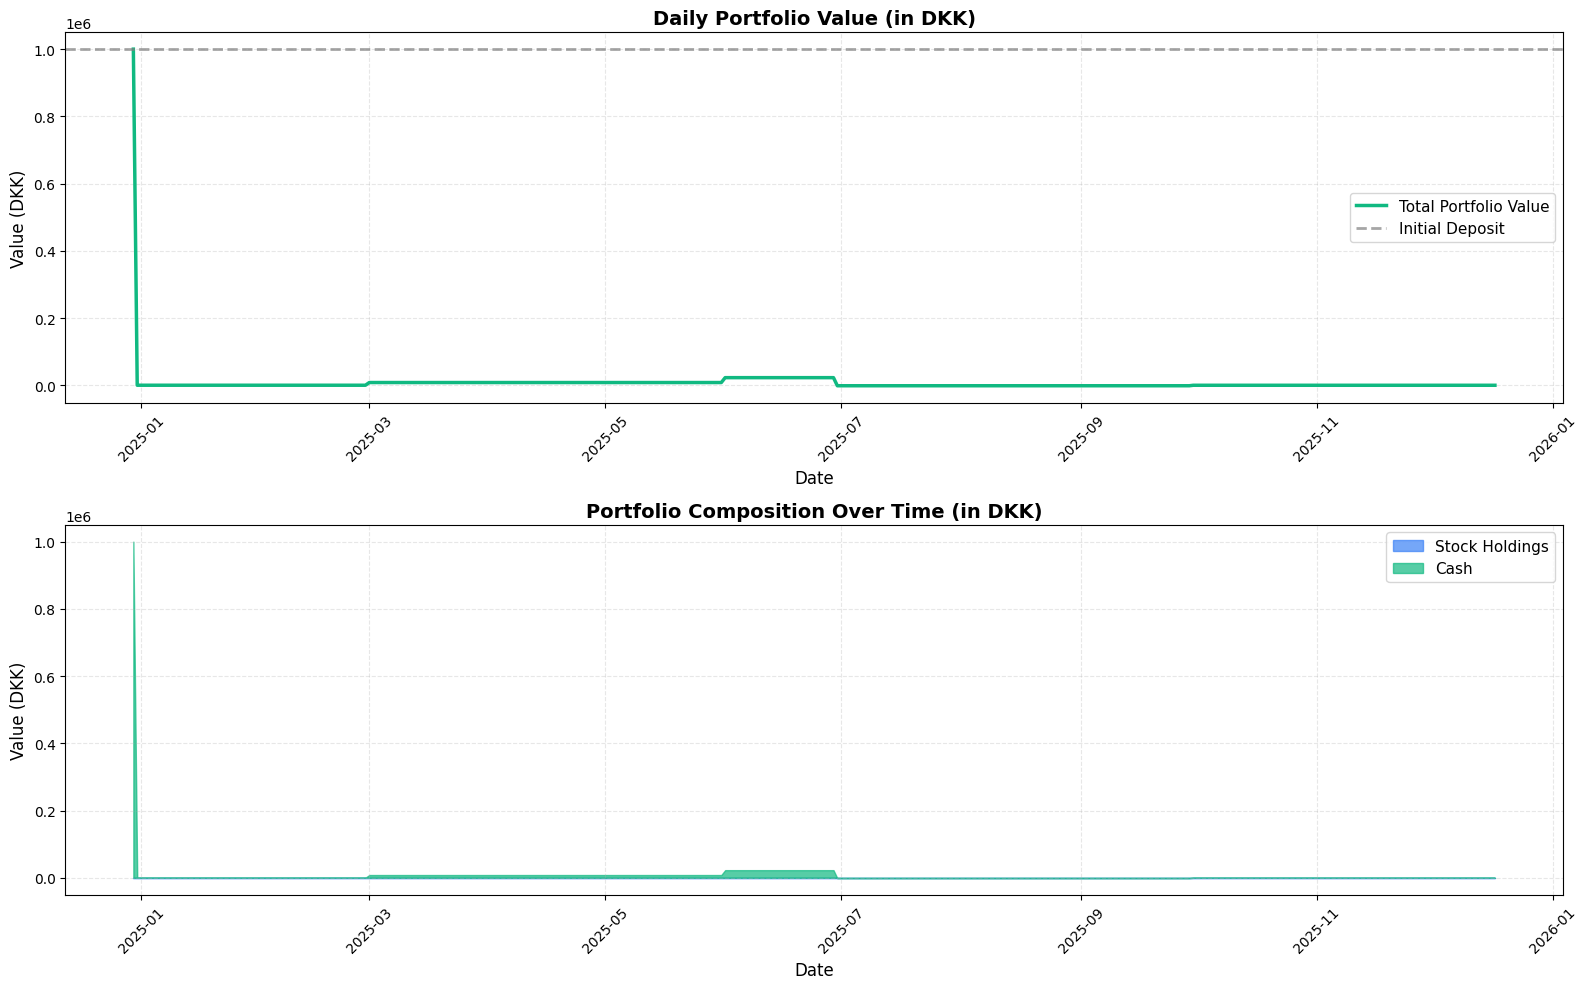


✓ Daily portfolio development completed


In [33]:
# Cell 12: Daily Portfolio Development
if portfolio_config is None:
    print("Please create a portfolio configuration first (Cell 4)")
elif transactions.empty:
    print("No transactions to analyze")
else:
    print("Calculating daily portfolio development...")
    print("This may take a moment as we fetch historical prices...\n")
    
    #holdings = calculate_holdings_at_date(transactions, datetime.now().strftime('%Y-%m-%d'))
    holdings = calculate_holdings_at_date(transactions, end_date)

    if len(holdings) == 0:
        print("No stock holdings found. Cannot calculate daily development.")
    else:
        start_date = pd.to_datetime(portfolio_config['start_date'])
        

        #tickers = list(holdings.keys())
        #print("Fetching historical prices...")
        #historical_prices = get_historical_prices(tickers, start_date, nordnet_stock_ID)

        #history_start = start_date 
        #print(f"Fetching historical prices from {history_start.date()}...")
        #historical_prices = get_historical_prices(tickers, history_start, nordnet_stock_ID)

        ####
        # Get ALL unique tickers that have EVER been traded (not just current holdings)
        all_tickers = transactions[transactions['action'].isin(['buy', 'sell'])]['ticker'].unique()
        tickers = list(all_tickers)

        print(f"Fetching historical prices for {len(tickers)} tickers (all traded stocks)...")
        historical_prices = get_historical_prices(tickers, start_date, nordnet_stock_ID)
        ####

        date_range = pd.date_range(start=start_date, end=end_date, freq='D')
        
        daily_values = []
        
        for current_date in date_range:
            date_str = current_date.strftime('%Y-%m-%d')
            current_date_tz = current_date.tz_localize('America/New_York')
            
            holdings = calculate_holdings_at_date(transactions, date_str)
            
            stock_value = 0
            
            for ticker, holding in holdings.items():
                if ticker in historical_prices and historical_prices[ticker] is not None:
                    ticker_prices = historical_prices[ticker]
                    available_dates = ticker_prices.index[ticker_prices.index.tz_localize(None) <= current_date]
                    
                    if len(available_dates) > 0:
                        price_date = available_dates[-1]
                        price = ticker_prices[price_date]
                        
                        rate = get_exchange_rate(holding['currency'])
                        value_dkk = holding['quantity'] * price * rate
                        stock_value += value_dkk
            
            transactions_to_date = transactions[pd.to_datetime(transactions['date']) <= current_date]
            if len(transactions_to_date) > 0:
                rate = get_exchange_rate(portfolio_config['currency'])
                cash = portfolio_config['initial_deposit'] * rate
                
                for _, row in transactions_to_date.iterrows():
                    trans_rate = get_exchange_rate(row['currency'])
                    transaction_fee = row.get('transaction_fee', 0)
                    fx_fee = row.get('fx_fee', 0)
                    
                    if pd.isna(transaction_fee):
                        transaction_fee = 0
                    if pd.isna(fx_fee):
                        fx_fee = 0
                    
                    if row['action'] == 'buy':
                        total_cost = row['quantity'] * row['price'] * trans_rate
                        cash -= total_cost + transaction_fee + fx_fee
                    elif row['action'] == 'sell':
                        total_proceeds = row['quantity'] * row['price'] * trans_rate
                        cash += total_proceeds - transaction_fee - fx_fee
                    elif row['action'] == 'dividend':
                        dividend_amt = row.get('dividend_amount', 0)
                        if pd.notna(dividend_amt):
                            cash += dividend_amt * trans_rate
            else:
                rate = get_exchange_rate(portfolio_config['currency'])
                cash = portfolio_config['initial_deposit'] * rate
            
            total_value = stock_value + cash
            
            daily_values.append({
                'date': current_date,
                'stock_value': stock_value,
                'cash': cash,
                'total_value': total_value
            })
        
        daily_df = pd.DataFrame(daily_values)
        
        print(f"\n✓ Calculated {len(daily_df)} days of portfolio data")
        
        # CALCULATE DAILY RETURNS
        print("\n" + "="*80)
        print("CALCULATING DAILY RETURNS")
        print("="*80)
        daily_df['daily_return'] = daily_df['total_value'].pct_change()
        print(f"✓ Daily returns calculated")
        
        # FETCH BENCHMARK DATA
        print("\n" + "="*80)
        print(f"FETCHING BENCHMARK: {BENCHMARK_TICKER}")
        print("="*80)
        
        try:
            benchmark = yf.Ticker(BENCHMARK_TICKER)
            benchmark_hist = benchmark.history(start=start_date, end=end_date)
            
            print(f"✓ Downloaded {len(benchmark_hist)} days of benchmark data")
            
            if len(benchmark_hist) > 0:
                benchmark_returns = benchmark_hist['Close'].pct_change()
                
                if benchmark_returns.index.tz is not None:
                    benchmark_returns.index = benchmark_returns.index.tz_localize(None)
                
                daily_df['date'] = pd.to_datetime(daily_df['date'])
                daily_df = daily_df.set_index('date')
                daily_df['benchmark_return'] = benchmark_returns
                daily_df = daily_df.reset_index()
                
                print(f"✓ Benchmark merged successfully")
                print(f"✓ Final columns: {list(daily_df.columns)}")
            else:
                print(f"⚠ No benchmark data for {BENCHMARK_TICKER}")
        except Exception as e:
            print(f"⚠ Error fetching benchmark: {e}")
        
        # GENERATE PLOTS
        print("\n" + "="*80)
        print("GENERATING CHARTS")
        print("="*80)
        
        rate = get_exchange_rate(portfolio_config['currency'])
        initial_deposit_dkk = portfolio_config['initial_deposit'] * rate
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))
        
        ax1.plot(daily_df['date'], daily_df['total_value'], linewidth=2.5, 
                label='Total Portfolio Value', color='#10b981', marker='')
        
        ax1.axhline(y=initial_deposit_dkk, color='gray', linestyle='--', 
                   linewidth=2, alpha=0.7, label='Initial Deposit')
        
        ax1.set_xlabel('Date', fontsize=12)
        ax1.set_ylabel(f'Value ({BASE_CURRENCY})', fontsize=12)
        ax1.set_title(f'Daily Portfolio Value (in {BASE_CURRENCY})', fontsize=14, fontweight='bold')
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3, linestyle='--')
        ax1.tick_params(axis='x', rotation=45)
        
        ax2.fill_between(daily_df['date'], 0, daily_df['stock_value'], 
                        label='Stock Holdings', alpha=0.7, color='#3b82f6')
        ax2.fill_between(daily_df['date'], daily_df['stock_value'], 
                        daily_df['total_value'], 
                        label='Cash', alpha=0.7, color='#10b981')
        
        ax2.set_xlabel('Date', fontsize=12)
        ax2.set_ylabel(f'Value ({BASE_CURRENCY})', fontsize=12)
        ax2.set_title(f'Portfolio Composition Over Time (in {BASE_CURRENCY})', 
                     fontsize=14, fontweight='bold')
        ax2.legend(fontsize=11)
        ax2.grid(True, alpha=0.3, linestyle='--')
        ax2.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        print("\n✓ Daily portfolio development completed")


In [34]:
# Cell 13: Risk Metrics
if 'daily_df' not in locals():
    print("Run Cell 12 first")
elif 'benchmark_return' not in daily_df.columns:
    print("No benchmark data available - Cell 12 had issues")
else:
    print("Calculating risk metrics...\n")
    
    alpha, beta, sharpe, corr = calculate_portfolio_metrics(
        daily_df['daily_return'].dropna(),
        daily_df['benchmark_return'].dropna()
    )
    
    if alpha is not None:
        # Calculate portfolio metrics
        daily_returns = daily_df['daily_return'].dropna()
        portfolio_return_annual = daily_returns.mean() * 252 * 100
        portfolio_volatility_annual = daily_returns.std() * np.sqrt(252) * 100
        
        # Calculate portfolio Sortino
        negative_returns = daily_returns[daily_returns < 0]
        downside_deviation = negative_returns.std() * np.sqrt(252)
        portfolio_sortino = ((daily_returns.mean() * 252 - RISK_FREE_RATE) / downside_deviation) if downside_deviation > 0 else 0
        
        # Calculate benchmark metrics
        benchmark_returns = daily_df['benchmark_return'].dropna()
        benchmark_return_annual = benchmark_returns.mean() * 252 * 100
        benchmark_volatility_annual = benchmark_returns.std() * np.sqrt(252) * 100
        
        # Calculate benchmark Sharpe
        benchmark_excess_returns = benchmark_returns - (RISK_FREE_RATE / 252)
        benchmark_sharpe = (benchmark_excess_returns.mean() / benchmark_excess_returns.std()) * np.sqrt(252) if benchmark_excess_returns.std() > 0 else 0
        
        # Calculate benchmark Sortino
        benchmark_negative_returns = benchmark_returns[benchmark_returns < 0]
        benchmark_downside_deviation = benchmark_negative_returns.std() * np.sqrt(252)
        benchmark_sortino = ((benchmark_returns.mean() * 252 - RISK_FREE_RATE) / benchmark_downside_deviation) if benchmark_downside_deviation > 0 else 0
        
        # Calculate portfolio drawdown and Calmar
        cumulative_returns = (1 + daily_returns).cumprod()
        running_max = cumulative_returns.expanding().max()
        drawdown = (cumulative_returns - running_max) / running_max
        max_drawdown = drawdown.min() * 100
        calmar_ratio = (portfolio_return_annual / abs(max_drawdown)) if max_drawdown != 0 else 0
        
        # Calculate benchmark drawdown and Calmar
        benchmark_cumulative = (1 + benchmark_returns).cumprod()
        benchmark_running_max = benchmark_cumulative.expanding().max()
        benchmark_drawdown = (benchmark_cumulative - benchmark_running_max) / benchmark_running_max
        benchmark_max_drawdown = benchmark_drawdown.min() * 100
        benchmark_calmar = (benchmark_return_annual / abs(benchmark_max_drawdown)) if benchmark_max_drawdown != 0 else 0
        
        # Calculate additional metrics
        active_returns = daily_returns - benchmark_returns
        information_ratio = (active_returns.mean() / active_returns.std()) * np.sqrt(252) if active_returns.std() > 0 else 0
        
        # Create summary table
        metrics_data = {
            'Metric': [
                'Annual Return',
                'Annual Volatility',
                'Sharpe Ratio',
                'Sortino Ratio',
                'Alpha (α)',
                'Beta (β)',
                'Information Ratio',
                'Correlation',
                'Maximum Drawdown',
                'Calmar Ratio'
            ],
            'Portfolio': [
                f"{portfolio_return_annual:.2f}%",
                f"{portfolio_volatility_annual:.2f}%",
                f"{sharpe:.3f}",
                f"{portfolio_sortino:.3f}",
                f"{alpha*100:.2f}%",
                f"{beta:.3f}",
                f"{information_ratio:.3f}",
                f"{corr:.3f}",
                f"{max_drawdown:.2f}%",
                f"{calmar_ratio:.3f}"
            ],
            'Benchmark': [
                f"{benchmark_return_annual:.2f}%",
                f"{benchmark_volatility_annual:.2f}%",
                f"{benchmark_sharpe:.3f}",
                f"{benchmark_sortino:.3f}",
                "0.00%",
                "1.000",
                "-",
                "1.000",
                f"{benchmark_max_drawdown:.2f}%",
                f"{benchmark_calmar:.3f}"
            ]
        }
        
        metrics_df = pd.DataFrame(metrics_data)
        
        print(f"{'='*100}")
        print(f"📈 COMPREHENSIVE RISK-ADJUSTED PERFORMANCE METRICS")
        print(f"{'='*100}")
        print(f"Benchmark: {BENCHMARK_TICKER}")
        print(f"Risk-Free Rate: {RISK_FREE_RATE*100:.1f}%")
        print(f"Analysis Period: {daily_df['date'].min().date()} to {daily_df['date'].max().date()}")
        print(f"Number of Trading Days: {len(daily_returns)}")
        print(f"{'='*100}\n")
        
        display(metrics_df)
        
        print(f"\n{'='*100}")
        print(f"📚 KEY INTERPRETATIONS")
        print(f"{'='*100}")
        
        print(f"\n🎯 RETURN COMPARISON:")
        return_diff = portfolio_return_annual - benchmark_return_annual
        print(f"  • Portfolio Return: {portfolio_return_annual:.2f}% vs Benchmark: {benchmark_return_annual:.2f}%")
        print(f"  • Difference: {return_diff:+.2f}% ({'OUTPERFORMING' if return_diff > 0 else 'UNDERPERFORMING'})")
        
        print(f"\n📊 RISK COMPARISON:")
        print(f"  • Portfolio Volatility: {portfolio_volatility_annual:.2f}% vs Benchmark: {benchmark_volatility_annual:.2f}%")
        print(f"  • Your portfolio is {'MORE' if portfolio_volatility_annual > benchmark_volatility_annual else 'LESS'} volatile")
        
        print(f"\n💎 RISK-ADJUSTED PERFORMANCE:")
        print(f"  • Portfolio Sharpe: {sharpe:.3f} vs Benchmark Sharpe: {benchmark_sharpe:.3f}")
        if sharpe > benchmark_sharpe:
            print(f"    → ✓ EXCELLENT: You have better risk-adjusted returns than the benchmark!")
        elif sharpe > benchmark_sharpe * 0.9:
            print(f"    → Good: Similar risk-adjusted performance to benchmark")
        else:
            print(f"    → Consider: Benchmark has better risk-adjusted returns")
        
        print(f"  • Portfolio Sortino: {portfolio_sortino:.3f} vs Benchmark Sortino: {benchmark_sortino:.3f}")
        if portfolio_sortino > benchmark_sortino:
            print(f"    → ✓ EXCELLENT: Better downside-adjusted returns!")
        
        print(f"\n🎲 MARKET RELATIONSHIP:")
        print(f"  • Alpha: {alpha*100:.2f}%")
        if alpha > 0.02:
            print(f"    → ✓ EXCELLENT: Significant outperformance vs benchmark")
        elif alpha > 0:
            print(f"    → Good: Positive alpha - adding value")
        else:
            print(f"    → Consider: Negative alpha - underperforming")
        
        print(f"  • Beta: {beta:.3f}")
        if beta > 1.2:
            print(f"    → High volatility - amplifies market movements (±20%+)")
        elif beta > 0.8:
            print(f"    → Moderate - moves with market")
        else:
            print(f"    → Low volatility - defensive portfolio")
        
        print(f"\n📉 DOWNSIDE RISK:")
        print(f"  • Portfolio Max Drawdown: {max_drawdown:.2f}% vs Benchmark: {benchmark_max_drawdown:.2f}%")
        if abs(max_drawdown) < abs(benchmark_max_drawdown):
            print(f"    → ✓ EXCELLENT: Lower maximum loss than benchmark!")
        elif abs(max_drawdown) < abs(benchmark_max_drawdown) * 1.2:
            print(f"    → Good: Similar downside risk to benchmark")
        else:
            print(f"    → Warning: Higher maximum loss than benchmark")
        
        print(f"  • Portfolio Calmar: {calmar_ratio:.3f} vs Benchmark Calmar: {benchmark_calmar:.3f}")
        if calmar_ratio > benchmark_calmar:
            print(f"    → ✓ EXCELLENT: Better return per unit of maximum risk!")
        elif calmar_ratio > benchmark_calmar * 0.9:
            print(f"    → Good: Comparable risk-adjusted performance")
        else:
            print(f"    → Consider: Benchmark has better Calmar ratio")
        
        print(f"\n{'='*100}")
        print(f"✅ OVERALL ASSESSMENT:")
        
        score = 0
        if alpha > 0: score += 1
        if sharpe > benchmark_sharpe: score += 1
        if portfolio_sortino > benchmark_sortino: score += 1
        if information_ratio > 0: score += 1
        if max_drawdown > -20: score += 1
        
        if score >= 4:
            overall = "⭐⭐⭐ STRONG: Outperforming benchmark across multiple metrics"
        elif score >= 3:
            overall = "⭐⭐ GOOD: Solid performance with some areas of strength"
        elif score >= 2:
            overall = "⭐ MODERATE: Mixed results - consider strategy review"
        else:
            overall = "⚠ NEEDS IMPROVEMENT: Underperforming on most metrics"
        
        print(f"  {overall}")
        print(f"  Performance Score: {score}/5 positive indicators")
        print(f"{'='*100}\n")
        
    else:
        print("Not enough data (need 30+ days)")


No benchmark data available - Cell 12 had issues


In [35]:
# Cell 14: Risk Metrics Visualization
if 'daily_df' not in locals() or 'benchmark_return' not in daily_df.columns:
    print("Please run Cell 12 first to calculate portfolio and benchmark data")
else:
    print("Generating risk analysis charts...")
    
    # Create figure with multiple subplots
    fig = plt.figure(figsize=(16, 12))
    
    # 1. Cumulative Returns Comparison
    ax1 = plt.subplot(3, 2, 1)
    portfolio_cumulative = (1 + daily_df['daily_return'].fillna(0)).cumprod() - 1
    benchmark_cumulative = (1 + daily_df['benchmark_return'].fillna(0)).cumprod() - 1
    
    ax1.plot(daily_df['date'], portfolio_cumulative * 100, label='Portfolio', linewidth=2, color='#10b981')
    ax1.plot(daily_df['date'], benchmark_cumulative * 100, label='Benchmark', linewidth=2, color='#6366f1', linestyle='--')
    ax1.set_title('Cumulative Returns Comparison', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Cumulative Return (%)', fontsize=10)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # 2. Rolling Beta (30-day window)
    ax2 = plt.subplot(3, 2, 2)
    rolling_window = 30
    rolling_cov = daily_df['daily_return'].rolling(window=rolling_window).cov(daily_df['benchmark_return'])
    rolling_var = daily_df['benchmark_return'].rolling(window=rolling_window).var()
    rolling_beta = rolling_cov / rolling_var
    
    ax2.plot(daily_df['date'], rolling_beta, linewidth=2, color='#f59e0b')
    ax2.axhline(y=1, color='gray', linestyle='--', alpha=0.5, label='Beta = 1')
    ax2.set_title(f'Rolling Beta ({rolling_window}-day window)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Beta', fontsize=10)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Rolling Sharpe Ratio (30-day window)
    ax3 = plt.subplot(3, 2, 3)
    rolling_excess_returns = daily_df['daily_return'] - (RISK_FREE_RATE / 252)
    rolling_sharpe = (rolling_excess_returns.rolling(window=rolling_window).mean() / 
                     rolling_excess_returns.rolling(window=rolling_window).std()) * np.sqrt(252)
    
    ax3.plot(daily_df['date'], rolling_sharpe, linewidth=2, color='#8b5cf6')
    ax3.axhline(y=1, color='green', linestyle='--', alpha=0.5, label='Sharpe = 1')
    ax3.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Sharpe = 0')
    ax3.set_title(f'Rolling Sharpe Ratio ({rolling_window}-day window)', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Sharpe Ratio', fontsize=10)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.tick_params(axis='x', rotation=45)
    
    # 4. Scatter plot: Portfolio vs Benchmark Returns
    ax4 = plt.subplot(3, 2, 4)
    returns_df = pd.DataFrame({
        'portfolio': daily_df['daily_return'].dropna(),
        'benchmark': daily_df['benchmark_return'].dropna()
    }).dropna()
    
    ax4.scatter(returns_df['benchmark'] * 100, returns_df['portfolio'] * 100, 
               alpha=0.5, s=20, color='#3b82f6')
    
    # Add regression line
    if len(returns_df) > 0:
        z = np.polyfit(returns_df['benchmark'], returns_df['portfolio'], 1)
        p = np.poly1d(z)
        x_line = np.linspace(returns_df['benchmark'].min(), returns_df['benchmark'].max(), 100)
        ax4.plot(x_line * 100, p(x_line) * 100, "r--", linewidth=2, 
                label=f'β = {z[0]:.2f}')
    
    ax4.set_xlabel('Benchmark Daily Return (%)', fontsize=10)
    ax4.set_ylabel('Portfolio Daily Return (%)', fontsize=10)
    ax4.set_title('Portfolio vs Benchmark Returns (Beta)', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.axhline(y=0, color='black', linewidth=0.5)
    ax4.axvline(x=0, color='black', linewidth=0.5)
    
    # 5. Volatility Comparison (Rolling Std)
    ax5 = plt.subplot(3, 2, 5)
    portfolio_volatility = daily_df['daily_return'].rolling(window=rolling_window).std() * np.sqrt(252) * 100
    benchmark_volatility = daily_df['benchmark_return'].rolling(window=rolling_window).std() * np.sqrt(252) * 100
    
    ax5.plot(daily_df['date'], portfolio_volatility, label='Portfolio', linewidth=2, color='#10b981')
    ax5.plot(daily_df['date'], benchmark_volatility, label='Benchmark', linewidth=2, color='#6366f1')
    ax5.set_title(f'Rolling Volatility ({rolling_window}-day, annualized)', fontsize=12, fontweight='bold')
    ax5.set_ylabel('Volatility (%)', fontsize=10)
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    ax5.tick_params(axis='x', rotation=45)
    
    # 6. Drawdown Analysis
    ax6 = plt.subplot(3, 2, 6)
    cumulative_value = daily_df['total_value']
    running_max = cumulative_value.expanding().max()
    drawdown = ((cumulative_value - running_max) / running_max) * 100
    
    ax6.fill_between(daily_df['date'], drawdown, 0, alpha=0.3, color='red')
    ax6.plot(daily_df['date'], drawdown, linewidth=2, color='red')
    ax6.set_title('Portfolio Drawdown', fontsize=12, fontweight='bold')
    ax6.set_ylabel('Drawdown (%)', fontsize=10)
    ax6.grid(True, alpha=0.3)
    ax6.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate additional statistics
    max_drawdown = drawdown.min()
    current_drawdown = drawdown.iloc[-1]
    
    print(f"\n{'='*80}")
    print(f"📉 DRAWDOWN ANALYSIS")
    print(f"{'='*80}")
    print(f"Maximum Drawdown:        {max_drawdown:.2f}%")
    print(f"Current Drawdown:        {current_drawdown:.2f}%")
    print(f"{'='*80}")
    
    print("\n✓ Risk metrics visualization completed")


Please run Cell 12 first to calculate portfolio and benchmark data


In [36]:
# Cell 15: Individual Stock Performance Analysis
if portfolio_config is None or transactions.empty:
    print("Please create portfolio and add transactions first")
else:
    print("📊 Analyzing individual stock performance over portfolio lifetime...\n")
    
    # Get all stocks that have been traded
    all_stocks = transactions[transactions['action'].isin(['buy', 'sell'])]['ticker'].unique()
    
    if len(all_stocks) == 0:
        print("No stock transactions found")
    else:
        start_date = pd.to_datetime(portfolio_config['start_date'])
        #end_date = pd.to_datetime('2025-04-01')
        #end_date = pd.to_datetime(datetime.now().strftime('%Y-%m-%d'))
        
        print(f"Fetching historical data for {len(all_stocks)} stocks from {start_date.date()} to {end_date.date()}...")
        
        stock_data = {}
        stock_first_purchase = {}
        
        # Find first purchase date for each stock
        for stock in all_stocks:
            stock_transactions = transactions[transactions['ticker'] == stock]
            first_buy = stock_transactions[stock_transactions['action'] == 'buy']['date'].min()
            if pd.notna(first_buy):
                stock_first_purchase[stock] = pd.to_datetime(first_buy)
        
        # Fetch historical prices
        #for stock in all_stocks:
        #    try:
        #        ticker_obj = yf.Ticker(stock)
        #        hist = ticker_obj.history(start=start_date, end=end_date)
        ##        print('hist: ', hist)
        #        
        #        if not hist.empty:
        #            stock_data[stock] = hist['Close']
        #            print('Close:', hist['Close'])
        #            print(f"  ✓ {stock}: {len(hist)} days of data")
        #        else:
        #            print(f"  ⚠ {stock}: No data available")
        #    except Exception as e:
        #        print(f"  ✗ {stock}: Error - {e}")
        
        for stock in all_stocks:
            try:
                # Automatic detection: Use Nordnet for Danish stocks if available
                if stock.endswith('.CO') and nordnet_stock_ID and stock in nordnet_stock_ID:
                    print(f"  Fetching {stock} from Nordnet...")
                    hist = get_nordnet_history(stock, nordnet_stock_ID, start=start_date)
                    print('stock:', stock, hist['Close'].loc['2025-03-31'])
                else:
                    print(f"  Fetching {stock} from Yahoo Finance...")
                    ticker_obj = yf.Ticker(stock)
                    hist = ticker_obj.history(start=start_date, end=end_date)
                    print('stock:', stock, hist['Close'].loc['2025-03-31'])
                if not hist.empty:
                    stock_data[stock] = hist['Close']
                    print(f"  ✓ {stock}: {len(hist)} days of data")
                else:
                    print(f"  ⚠ {stock}: No data available")
            except Exception as e:
                print(f"  ✗ {stock}: Error - {e}")


        if stock_data:
            # Create comprehensive visualization
            fig = plt.figure(figsize=(16, 14))
            
            # 1. Absolute Price Performance
            ax1 = plt.subplot(3, 2, 1)
            colors = plt.cm.tab10(range(len(stock_data)))
            
            for i, (stock, prices) in enumerate(stock_data.items()):
                ax1.plot(prices.index, prices.values, label=stock, linewidth=2, color=colors[i], alpha=0.8)
                
                # Mark first purchase date
                if stock in stock_first_purchase:
                    first_date = stock_first_purchase[stock]
                    # Find closest date in price data
                    # Ensure first_date has timezone to match prices.index
                    if first_date.tz is None and len(prices.index) > 0 and prices.index[0].tz is not None:
                        first_date_tz = first_date.tz_localize(prices.index[0].tz)
                    else:
                        first_date_tz = first_date
                    
                    closest_date = prices.index[prices.index >= first_date_tz][0] if any(prices.index >= first_date_tz) else None
                    if closest_date is not None:
                        price_at_purchase = prices[closest_date]
                        ax1.scatter(closest_date, price_at_purchase, color=colors[i], s=100, 
                                   marker='o', edgecolors='black', linewidth=2, zorder=5)
            
            ax1.set_title('Stock Price Development (Absolute)', fontsize=13, fontweight='bold')
            ax1.set_ylabel('Price', fontsize=11)
            ax1.legend(loc='best', fontsize=9)
            ax1.grid(True, alpha=0.3)
            ax1.tick_params(axis='x', rotation=45)
            
            # 2. Normalized Performance (all start at 100)
            ax2 = plt.subplot(3, 2, 2)
            
            for i, (stock, prices) in enumerate(stock_data.items()):
                # Normalize to 100 at portfolio start or first purchase
                if stock in stock_first_purchase:
                    first_date = stock_first_purchase[stock]
                    # Ensure first_date has timezone to match prices.index
                    if first_date.tz is None and len(prices) > 0 and prices.index[0].tz is not None:
                        first_date = first_date.tz_localize(prices.index[0].tz)
                    
                    start_idx = prices.index >= first_date
                    if start_idx.any():
                        normalized_prices = prices[start_idx]
                        normalized = (normalized_prices / normalized_prices.iloc[0]) * 100
                        ax2.plot(normalized.index, normalized.values, label=stock, 
                                linewidth=2, color=colors[i], alpha=0.8)
                else:
                    normalized = (prices / prices.iloc[0]) * 100
                    ax2.plot(normalized.index, normalized.values, label=stock, 
                            linewidth=2, color=colors[i], alpha=0.8)
            
            ax2.axhline(y=100, color='gray', linestyle='--', linewidth=1, alpha=0.5)
            ax2.set_title('Stock Performance (Normalized to 100 at purchase)', fontsize=13, fontweight='bold')
            ax2.set_ylabel('Indexed Value', fontsize=11)
            ax2.legend(loc='best', fontsize=9)
            ax2.grid(True, alpha=0.3)
            ax2.tick_params(axis='x', rotation=45)
            
            # 3. Cumulative Returns
            ax3 = plt.subplot(3, 2, 3)
            
            for i, (stock, prices) in enumerate(stock_data.items()):
                returns = prices.pct_change()
                cumulative_returns = (1 + returns).cumprod() - 1
                ax3.plot(cumulative_returns.index, cumulative_returns.values * 100, 
                        label=stock, linewidth=2, color=colors[i], alpha=0.8)
            
            ax3.axhline(y=0, color='gray', linestyle='-', linewidth=1, alpha=0.5)
            ax3.set_title('Cumulative Returns (%)', fontsize=13, fontweight='bold')
            ax3.set_ylabel('Return (%)', fontsize=11)
            ax3.legend(loc='best', fontsize=9)
            ax3.grid(True, alpha=0.3)
            ax3.tick_params(axis='x', rotation=45)
            
            # 4. Rolling Volatility (30-day)
            ax4 = plt.subplot(3, 2, 4)
            
            for i, (stock, prices) in enumerate(stock_data.items()):
                returns = prices.pct_change()
                rolling_vol = returns.rolling(window=30).std() * np.sqrt(252) * 100
                ax4.plot(rolling_vol.index, rolling_vol.values, label=stock, 
                        linewidth=2, color=colors[i], alpha=0.8)
            
            ax4.set_title('Rolling Volatility (30-day, annualized)', fontsize=13, fontweight='bold')
            ax4.set_ylabel('Volatility (%)', fontsize=11)
            ax4.legend(loc='best', fontsize=9)
            ax4.grid(True, alpha=0.3)
            ax4.tick_params(axis='x', rotation=45)
            
            # 5. Distribution of Daily Returns
            ax5 = plt.subplot(3, 2, 5)
            
            for i, (stock, prices) in enumerate(stock_data.items()):
                returns = prices.pct_change().dropna() * 100
                ax5.hist(returns, bins=50, alpha=0.5, label=stock, color=colors[i])
            
            ax5.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.7)
            ax5.set_title('Distribution of Daily Returns', fontsize=13, fontweight='bold')
            ax5.set_xlabel('Daily Return (%)', fontsize=11)
            ax5.set_ylabel('Frequency', fontsize=11)
            ax5.legend(loc='best', fontsize=9)
            ax5.grid(True, alpha=0.3, axis='y')
            
            # 6. Performance Summary Table (as text in plot)
            ax6 = plt.subplot(3, 2, 6)
            ax6.axis('off')
            
            # Calculate performance metrics for each stock
            performance_data = []
            
            for stock, prices in stock_data.items():
                returns = prices.pct_change().dropna()
                
                # Total return from first purchase
                if stock in stock_first_purchase:
                    first_date = stock_first_purchase[stock]
                    # Ensure first_date has timezone to match prices.index
                    if first_date.tz is None and len(prices) > 0 and prices.index[0].tz is not None:
                        first_date = first_date.tz_localize(prices.index[0].tz)
                    
                    start_idx = prices.index >= first_date
                    if start_idx.any():
                        relevant_prices = prices[start_idx]
                        total_return = ((relevant_prices.iloc[-1] / relevant_prices.iloc[0]) - 1) * 100
                        days_held = (relevant_prices.index[-1] - relevant_prices.index[0]).days
                    else:
                        total_return = 0
                        days_held = 0
                else:
                    total_return = ((prices.iloc[-1] / prices.iloc[0]) - 1) * 100
                    days_held = (prices.index[-1] - prices.index[0]).days
                
                volatility = returns.std() * np.sqrt(252) * 100
                sharpe = (returns.mean() * 252) / (returns.std() * np.sqrt(252)) if returns.std() > 0 else 0
                
                # Best and worst day
                best_day = returns.max() * 100
                worst_day = returns.min() * 100
                
                performance_data.append({
                    'Stock': stock,
                    'Total Return': f"{total_return:+.2f}%",
                    'Days Held': days_held,
                    'Volatility': f"{volatility:.2f}%",
                    'Sharpe': f"{sharpe:.2f}",
                    'Best Day': f"{best_day:+.2f}%",
                    'Worst Day': f"{worst_day:+.2f}%"
                })
            
            perf_df = pd.DataFrame(performance_data)
            
            # Create table
            table_text = perf_df.to_string(index=False)
            ax6.text(0.1, 0.9, 'STOCK PERFORMANCE SUMMARY', 
                    fontsize=13, fontweight='bold', verticalalignment='top')
            ax6.text(0.1, 0.8, table_text, 
                    fontsize=9, verticalalignment='top', family='monospace')
            
            plt.tight_layout()
            plt.show()
            
            print("\n✓ Individual stock performance analysis completed")
            
            # Print detailed performance table
            print(f"\n{'='*100}")
            print(f"📈 DETAILED STOCK PERFORMANCE METRICS")
            print(f"{'='*100}\n")
            display(perf_df)
        else:
            print("\n⚠ No stock data available for analysis")


📊 Analyzing individual stock performance over portfolio lifetime...

Fetching historical data for 14 stocks from 2024-12-30 to 2025-12-17...
  Fetching NOVO-B.CO from Nordnet...
  ✗ NOVO-B.CO: Error - Error fetching data from Nordnet for NOVO-B.CO: HTTPSConnectionPool(host='api.prod.nntech.io', port=443): Max retries exceeded with url: /market-data/price-time-series/v2/period/YEAR_5/identifier/16256554?resolution=DAY&enrichType=ALL (Caused by NewConnectionError("HTTPSConnection(host='api.prod.nntech.io', port=443): Failed to establish a new connection: [WinError 10013] Det blev forsøgt at få adgang til en socket på en måde, der er forbudt af den pågældende sockets adgangstilladelser"))
  Fetching DEMANT.CO from Nordnet...
  ✗ DEMANT.CO: Error - Error fetching data from Nordnet for DEMANT.CO: HTTPSConnectionPool(host='api.prod.nntech.io', port=443): Max retries exceeded with url: /market-data/price-time-series/v2/period/YEAR_5/identifier/bf111a08-d545-449d-add7-4783af800242?resolution=D

In [37]:
# Cell 16: Portfolio Statistics Table (by Week/Month)
if portfolio_config is None or 'daily_df' not in locals():
    print("Please run Cell 12 first to calculate daily portfolio values")
else:
    print("📊 Portfolio Performance Summary\n")
    
    # Weekly summary
    daily_df['week'] = daily_df['date'].dt.to_period('W')
    weekly_df = daily_df.groupby('week').agg({
        'total_value': 'last',
        'stock_value': 'last',
        'cash': 'last'
    }).reset_index()
    weekly_df['week'] = weekly_df['week'].astype(str)
    
    # Calculate weekly returns
    weekly_df['return'] = weekly_df['total_value'].pct_change() * 100
    weekly_df['return'] = weekly_df['return'].fillna(0)
    
    print("📅 Weekly Portfolio Values (Last 10 weeks):")
    display(weekly_df.tail(10))
    
    # Monthly summary
    daily_df['month'] = daily_df['date'].dt.to_period('M')
    monthly_df = daily_df.groupby('month').agg({
        'total_value': 'last',
        'stock_value': 'last',
        'cash': 'last'
    }).reset_index()
    monthly_df['month'] = monthly_df['month'].astype(str)
    
    # Calculate monthly returns
    monthly_df['return'] = monthly_df['total_value'].pct_change() * 100
    monthly_df['return'] = monthly_df['return'].fillna(0)
    
    print("\n📅 Monthly Portfolio Values:")
    display(monthly_df)
    
    # Overall statistics
    rate = get_exchange_rate(portfolio_config['currency'])
    initial_deposit_dkk = portfolio_config['initial_deposit'] * rate
    final_value = daily_df['total_value'].iloc[-1]
    total_return = final_value - initial_deposit_dkk
    total_return_pct = (total_return / initial_deposit_dkk * 100)
    
    # Calculate number of days
    num_days = (daily_df['date'].iloc[-1] - daily_df['date'].iloc[0]).days
    annualized_return = (((final_value / initial_deposit_dkk) ** (365 / num_days)) - 1) * 100 if num_days > 0 else 0
    
    print(f"\n{'='*80}")
    print(f"📈 OVERALL PERFORMANCE STATISTICS")
    print(f"{'='*80}")
    print(f"Start Date:               {portfolio_config['start_date']}")
    print(f"Days Active:              {num_days}")
    print(f"Initial Deposit:          {initial_deposit_dkk:,.2f} {BASE_CURRENCY}")
    print(f"Current Value:            {final_value:,.2f} {BASE_CURRENCY}")
    print(f"Total Return:             {total_return:+,.2f} {BASE_CURRENCY} ({total_return_pct:+.2f}%)")
    print(f"Annualized Return:        {annualized_return:+.2f}%")
    print(f"{'='*80}")


📊 Portfolio Performance Summary

📅 Weekly Portfolio Values (Last 10 weeks):


,week,total_value,stock_value,cash,return
41,2025-10-13/2025-10-19,-52.7,0,-52.7,0.0
42,2025-10-20/2025-10-26,-52.7,0,-52.7,0.0
43,2025-10-27/2025-11-02,-52.7,0,-52.7,0.0
44,2025-11-03/2025-11-09,-52.7,0,-52.7,0.0
45,2025-11-10/2025-11-16,-52.7,0,-52.7,0.0
46,2025-11-17/2025-11-23,-52.7,0,-52.7,0.0
47,2025-11-24/2025-11-30,-52.7,0,-52.7,0.0
48,2025-12-01/2025-12-07,-52.7,0,-52.7,0.0
49,2025-12-08/2025-12-14,-52.7,0,-52.7,0.0
50,2025-12-15/2025-12-21,-52.7,0,-52.7,0.0



📅 Monthly Portfolio Values:


,month,total_value,stock_value,cash,return
0,2024-12,60.8,0,60.8,0.000000
1,2025-01,60.8,0,60.8,0.000000
2,2025-02,60.8,0,60.8,0.000000
3,2025-03,8091.8,0,8091.8,13208.881579
4,2025-04,8091.8,0,8091.8,0.000000
5,2025-05,8091.8,0,8091.8,0.000000
6,2025-06,-1465.2,0,-1465.2,-118.107220
7,2025-07,-1465.2,0,-1465.2,0.000000
8,2025-08,-1465.2,0,-1465.2,0.000000
9,2025-09,-52.7,0,-52.7,-96.403221



📈 OVERALL PERFORMANCE STATISTICS
Start Date:               2024-12-30
Days Active:              352
Initial Deposit:          1,000,000.00 DKK
Current Value:            -52.70 DKK
Total Return:             -1,000,052.70 DKK (-100.01%)
Annualized Return:        +nan%


In [38]:
# Cell 17: Export Daily Portfolio Data
if 'daily_df' in locals():
    # Export to CSV
    daily_df.to_csv('daily_portfolio_values.csv', index=False)
    print("✓ Daily portfolio values exported to 'daily_portfolio_values.csv'")
    
    # Create detailed report
    report_date = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    with open('portfolio_report_detailed.txt', 'w', encoding='utf-8') as f:
        f.write("="*80 + "\n")
        f.write(f"DETAILED PORTFOLIO REPORT\n")
        f.write(f"Generated: {report_date}\n")
        f.write(f"Base Currency: {BASE_CURRENCY}\n")
        f.write("="*80 + "\n\n")
        
        f.write(f"Portfolio Configuration:\n")
        f.write(f"  Start Date: {portfolio_config['start_date']}\n")
        f.write(f"  Initial Deposit: {portfolio_config['initial_deposit']} {portfolio_config['currency']}\n\n")
        
        rate = get_exchange_rate(portfolio_config['currency'])
        initial_deposit_dkk = portfolio_config['initial_deposit'] * rate
        final_value = daily_df['total_value'].iloc[-1]
        total_return = final_value - initial_deposit_dkk
        total_return_pct = (total_return / initial_deposit_dkk * 100)
        
        f.write(f"Current Portfolio Status:\n")
        f.write(f"  Total Value: {final_value:,.2f} {BASE_CURRENCY}\n")
        f.write(f"  Stock Holdings: {daily_df['stock_value'].iloc[-1]:,.2f} {BASE_CURRENCY}\n")
        f.write(f"  Cash: {daily_df['cash'].iloc[-1]:,.2f} {BASE_CURRENCY}\n")
        f.write(f"  Total Return: {total_return:+,.2f} {BASE_CURRENCY} ({total_return_pct:+.2f}%)\n\n")
        
        f.write("="*80 + "\n")
        f.write("TRANSACTION HISTORY\n")
        f.write("="*80 + "\n")
        f.write(transactions.to_string(index=False))
        f.write("\n\n")
        
        f.write("="*80 + "\n")
        f.write("MONTHLY PERFORMANCE\n")
        f.write("="*80 + "\n")
        f.write(monthly_df.to_string(index=False))
    
    print("✓ Detailed portfolio report exported to 'portfolio_report_detailed.txt'")
else:
    print("Please run Cell 12 first to generate portfolio data")


✓ Daily portfolio values exported to 'daily_portfolio_values.csv'
✓ Detailed portfolio report exported to 'portfolio_report_detailed.txt'


In [39]:
# Cell 18: Portfolio Status Report
def generate_portfolio_report(status_date, start_date, end_date, nordnet_stock_ID=None, benchmark_tickers=['C25GI', 'C5Q1']):
    """
    Genererer portfolio status rapport som vist i billedet
    
    Args:
        status_date: Dato for status (f.eks. '2025-03-31')
        nordnet_stock_ID: Dictionary med Nordnet IDs
        benchmark_tickers: Liste med benchmark ticker symbols for sammenligning
    
    Returns:
        pandas DataFrame med portfolio oversigt
    """
    if portfolio_config is None:
        print("Create portfolio first")
        return None
    
    status_date_dt = pd.to_datetime(status_date)
    #start_date = pd.to_datetime(portfolio_config['start_date'])
    
    # Calculate quarter start (3 months back)
    quarter_start = status_date_dt - pd.DateOffset(months=3)
    
    # Get holdings at status date
    holdings = calculate_holdings_at_date(transactions, status_date)
    
    if not holdings:
        print("No holdings at this date")
        return None
    
    # Fetch prices at status date and quarter start
    tickers = list(holdings.keys())
    
    print(f"Fetching prices for status date {status_date}...")
    status_prices = get_current_prices(tickers, nordnet_stock_ID, start_date, end_date) # Note: this gets latest, adjust if needed
    
    print(f"Fetching historical prices...")
    historical = get_historical_prices(tickers, start_date, nordnet_stock_ID)
    
    ## if you want to go back delete these lines and the # in the above line
    #history_start = pd.to_datetime(start_date)- pd.DateOffset(days=5)
    #historical = get_historical_prices(tickers, history_start, nordnet_stock_ID)
    #if historical.index.isin('2024-12-30'):
    #    print('found 2024-12-30')
    ## if you want to go back delete these lines and the # in the above line


    # Calculate cash balance at status date
    trans_to_date = transactions[pd.to_datetime(transactions['date']) <= status_date_dt]
    rate = get_exchange_rate(portfolio_config['currency'])
    cash = portfolio_config['initial_deposit'] * rate
    
    for _, row in trans_to_date.iterrows():
        trans_rate = get_exchange_rate(row['currency'])
        t_fee = row.get('transaction_fee', 0) if pd.notna(row.get('transaction_fee', 0)) else 0
        f_fee = row.get('fx_fee', 0) if pd.notna(row.get('fx_fee', 0)) else 0
        
        if row['action'] == 'buy':
            cash -= row['quantity'] * row['price'] * trans_rate + t_fee + f_fee
        elif row['action'] == 'sell':
            cash += row['quantity'] * row['price'] * trans_rate - t_fee - f_fee
        elif row['action'] == 'dividend':
            div_amt = row.get('dividend_amount', 0)
            if pd.notna(div_amt):
                cash += div_amt * trans_rate
    
    # Build report data
    report_data = []
    total_purchase_value = 0
    total_current_value = 0
    
    for ticker, holding in holdings.items():
        quantity = holding['quantity']
        total_cost = holding['total_cost']
        avg_cost = total_cost / quantity
        currency = holding['currency']
        
        # Get exchange rate
        exch_rate = get_exchange_rate(currency)
        print(exch_rate)
        
        # Purchase value in DKK
        purchase_value_dkk = total_cost * exch_rate
        total_purchase_value += purchase_value_dkk
        
        # Current price and value
        current_price = status_prices.get(ticker)
        if current_price:
            current_value_dkk = quantity * current_price * exch_rate
            total_current_value += current_value_dkk
            
            # Get price 3 months ago for quarterly return
            if ticker in historical:
                prices_series = historical[ticker]
                quarter_prices = prices_series[prices_series.index >= quarter_start]
                
                if len(quarter_prices) > 0:
                    price_3m_ago = quarter_prices.iloc[0]
                    value_3m_ago = quantity * price_3m_ago * exch_rate
                    change_3m_kr = current_value_dkk - value_3m_ago
                    change_3m_pct = (change_3m_kr / value_3m_ago * 100) if value_3m_ago > 0 else 0
                else:
                    change_3m_kr = 0
                    change_3m_pct = 0
                
                # YTD return (from start of year)
                year_start = pd.Timestamp(f'{status_date_dt.year}-01-01')
                ytd_prices = prices_series[prices_series.index >= year_start]
                
                if len(ytd_prices) > 0:
                    price_ytd = ytd_prices.iloc[0]
                    value_ytd = quantity * price_ytd * exch_rate
                    change_ytd_pct = ((current_value_dkk - value_ytd) / value_ytd * 100) if value_ytd > 0 else 0
                else:
                    change_ytd_pct = 0
            else:
                change_3m_kr = 0
                change_3m_pct = 0
                change_ytd_pct = 0
            
            report_data.append({
                'Aktie': ticker,
                'Købs kurs': avg_cost,
                'Kurs status': current_price,
                'Købs værdi': purchase_value_dkk,
                f'Status kr. {status_date}': current_value_dkk,
                'Ændring 3 mdr.': change_3m_pct,
                #f'Ændring i {status_date_dt.year}': change_ytd_pct, # this is the original code by Claude. It uses the close price as purchase price for YTD instead of THorlef's purchase price.
                f'Ændring i {status_date_dt.year}': (current_value_dkk - purchase_value_dkk) / purchase_value_dkk * 100 if purchase_value_dkk > 0 else 0,
                'Vægt': 0  # Will calculate after we know total
            })
    
    # Create DataFrame
    report_df = pd.DataFrame(report_data)
    
    # Calculate weights
    total_portfolio_value = total_current_value + cash
    report_df['Vægt'] = (report_df[f'Status kr. {status_date}'] / total_portfolio_value * 100)
    
    # Add summary rows
    summary_rows = []
    
    summary_rows.append({
        'Aktie': None,
        'Købs kurs': None,
        'Kurs status': None,
        'Købs værdi': None,
        f'Status kr. {status_date}': None,
        'Ændring 3 mdr.': None,
        f'Ændring i {status_date_dt.year}': None,
        'Vægt': None
    })

    # Kontant row
    summary_rows.append({
        'Aktie': 'Kontant',
        'Købs kurs': None,
        'Kurs status': None,
        'Købs værdi': None,
        f'Status kr. {status_date}': cash,
        'Ændring 3 mdr.': None,
        f'Ændring i {status_date_dt.year}': None,
        'Vægt': (cash / total_portfolio_value * 100)
    })
    
    # I alt kr row
    total_change_3m = report_df['Ændring 3 mdr.'].sum()
    
    summary_rows.append({
        'Aktie': 'I alt kr',
        'Købs kurs': None,
        'Kurs status': None,
        'Købs værdi': None,
        f'Status kr. {status_date}': total_portfolio_value,
        'Ændring 3 mdr.': None,
        f'Ændring i {status_date_dt.year}': None,
        'Vægt': None
    })
    
    # I alt % row
    total_return_kr = total_portfolio_value - (portfolio_config['initial_deposit'] * get_exchange_rate(portfolio_config['currency']))
    total_return_pct = (total_return_kr / (portfolio_config['initial_deposit'] * get_exchange_rate(portfolio_config['currency'])) * 100)
    
    # YTD return
    year_start = pd.Timestamp(f'{status_date_dt.year}-01-01')
    # We need portfolio value at year start - simplified: use total purchase value as proxy
    ytd_return_pct = ((total_portfolio_value - total_purchase_value) / total_purchase_value * 100) if total_purchase_value > 0 else 0
    
    summary_rows.append({
        'Aktie': 'I alt %',
        'Købs kurs': None,
        'Kurs status': None,
        'Købs værdi': None,
        f'Status kr. {status_date}': None,
        'Ændring 3 mdr.': (total_change_3m / (total_portfolio_value - total_change_3m) * 100) if (total_portfolio_value - total_change_3m) > 0 else 0,
        f'Ændring i {status_date_dt.year}': ytd_return_pct,
        'Vægt': None
    })
    
    # Benchmark rows (C2M, C5 Q1, etc.)
    for bench_ticker in benchmark_tickers:
        try:
            bench = yf.Ticker(f'^{bench_ticker}')
            bench_hist = bench.history(start=quarter_start, end=status_date)
            
            if not bench_hist.empty:
                bench_current = bench_hist['Close'].iloc[-1]
                bench_3m_ago = bench_hist['Close'].iloc[0]
                bench_3m_return = ((bench_current - bench_3m_ago) / bench_3m_ago * 100)
                
                # YTD
                bench_ytd_hist = bench.history(start=year_start, end=status_date)
                if not bench_ytd_hist.empty:
                    bench_ytd_start = bench_ytd_hist['Close'].iloc[0]
                    bench_ytd_return = ((bench_current - bench_ytd_start) / bench_ytd_start * 100)
                else:
                    bench_ytd_return = 0
                
                summary_rows.append({
                    'Aktie': bench_ticker,
                    'Købs kurs': None,
                    'Kurs status': None,
                    'Købs værdi': None,
                    f'Status kr. {status_date}': None,
                    'Ændring 3 mdr.': bench_3m_return,
                    f'Ændring i {status_date_dt.year}': bench_ytd_return,
                    'Vægt': None
                })
        except Exception as e:
            print(f"Could not fetch benchmark {bench_ticker}: {e}")
    
    # Append summary rows
    summary_df = pd.DataFrame(summary_rows)
    final_df = pd.concat([report_df, summary_df], ignore_index=True)
    #final_df['Ændring 3 mdr.'] = final_df['Ændring 3 mdr.'].round(1)
    #final_df['Ændring i 2025 %'] = final_df['Ændring i 2025 %'].round(1)
    #final_df['Vægt'] = final_df['Vægt'].round(1)
    return final_df


# Example usage:
report = generate_portfolio_report('2025-12-17', '2024-12-31', '2025-12-17', nordnet_stock_ID=nordnet_stock_ID, benchmark_tickers=['OMXSPI'])


Fetching prices for status date 2025-12-17...
  ✗ Error fetching NOVO-B.CO: Error fetching data from Nordnet for NOVO-B.CO: HTTPSConnectionPool(host='api.prod.nntech.io', port=443): Max retries exceeded with url: /market-data/price-time-series/v2/period/YEAR_5/identifier/16256554?resolution=DAY&enrichType=ALL (Caused by NewConnectionError("HTTPSConnection(host='api.prod.nntech.io', port=443): Failed to establish a new connection: [WinError 10013] Det blev forsøgt at få adgang til en socket på en måde, der er forbudt af den pågældende sockets adgangstilladelser"))
  ✗ Error fetching DEMANT.CO: Error fetching data from Nordnet for DEMANT.CO: HTTPSConnectionPool(host='api.prod.nntech.io', port=443): Max retries exceeded with url: /market-data/price-time-series/v2/period/YEAR_5/identifier/bf111a08-d545-449d-add7-4783af800242?resolution=DAY&enrichType=ALL (Caused by NewConnectionError("HTTPSConnection(host='api.prod.nntech.io', port=443): Failed to establish a new connection: [WinError 1001

KeyError: 'Status kr. 2025-12-17'

In [ ]:

if report is not None:
    # Display with formatting
    styled_report = report.style.format({
        'Købs kurs': '{:.1f}',
        'Kurs status': '{:.1f}',
        'Købs værdi': '{:.1f}',
        'Status kr. 2025-04-01': '{:.1f}',
        'Ændring 3 mdr.': '{:.1f}%',
        'Ændring i 2025': '{:.1f}%',
        'Vægt': '{:.1f}%'
    }, na_rep='')
    
    display(styled_report)

#------
# Generer rapport for en specifik dato

#report = generate_portfolio_report(
#    status_date='2025-03-31',
#    nordnet_stock_ID=nordnet_stock_ID,
#    benchmark_tickers=['OMXC25GI', 'OMXSPI']  # Dine benchmark indeks
#)

,Aktie,Købs kurs,Kurs status,Købs værdi,Status kr. 2025-12-17,Ændring 3 mdr.,Ændring i 2025,Vægt
0,NOVO-B.CO,624.2,309.4,93630.0,46402.500000,-16.3%,-50.4%,4.6%
1,DEMANT.CO,264.2,213.8,89828.0,72692.000000,-9.7%,-19.1%,7.1%
2,STG.CO,95.3,94.0,90535.0,89300.000000,4.0%,-1.4%,8.8%
3,PNDORA.CO,1317.0,713.8,92190.0,49966.000000,-17.6%,-45.8%,4.9%
4,SCHO.CO,538.0,626.0,91460.0,106420.000000,3.8%,16.4%,10.5%
5,RBREW.CO,505.5,568.0,90990.0,102240.000000,16.6%,12.4%,10.0%
6,RILBA.CO,1204.0,1463.0,90300.0,109725.000000,0.1%,21.5%,10.8%
7,DNORD.CO,212.4,253.4,90270.0,107695.000000,2.3%,19.3%,10.6%
8,AOJ-B.CO,78.6,89.9,87796.2,100418.300000,-7.7%,14.4%,9.9%
9,GMAB.CO,1315.0,1986.5,69695.0,105284.500000,12.3%,51.1%,10.3%
